<a href="https://colab.research.google.com/github/gowtham91m/Analytics_Vidhya_hackathon/blob/master/Scene_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Statement
How do we, humans, recognize a forest as a forest or a mountain as a mountain? We are very good at categorizing scenes based on the semantic representation and object affinity, but we know very little about the processing and encoding of natural scene categories in the human brain. In this practice problem, you are provided with a dataset of ~25k images from a wide range of natural scenes from all around the world. Your task is to identify which natural scene can the image be categorized into.

DATASET DESCRIPTION
There are 17034 images in train and 7301 images in test data.
The categories of natural scenes and their corresponding labels in the dataset are as follows -

{     'buildings' -> 0,     'forest' -> 1,     'glacier' -> 2,     'mountain' -> 3,     'sea' -> 4,     'street' -> 5 }

###EVALUATION METRIC
The Evaluation metric for this competition is accuracy.

In [0]:
import os,shutil
import pandas as pd
import numpy as np
import keras
from keras import layers,models,optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
import cv2
from PIL import Image
from time import time

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
%%capture
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
root_dir = '/content'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
shutil.rmtree(data_dir)

In [35]:
data_dir = os.path.join(root_dir,'intel')
train_path =os.path.join(data_dir,'train/')

BATCH_SIZE = 32
SEED = 777
SHAPE = (250, 250, 3)

if 'intel' not in os.listdir(root_dir): 
  os.mkdir(data_dir)
  os.chdir(data_dir)
  zip_file = drive.CreateFile({'id': '10qN7OUzTutCg8ruwFosml0xzi0elsI5N'})
  zip_file.GetContentFile('train.zip')
  !unzip -q -o train.zip

  test_file = drive.CreateFile({'id': '1vXXq-oSfLtjxhHClcE7593bU4FV-tGVj'})
  test_file.GetContentFile('test.csv')
  
  sample_submission = test_file = drive.CreateFile({'id': '1UnfGdFbKC6oB6J3SYX5TjaW7fyQ3whqN'})
  sample_submission.GetContentFile('sample_submission.csv')
  
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(train.shape)
print(test.shape)
print(sample_submission.shape)
print('count of distinct target values - ',train.label.nunique())

# Train test split
X_train, X_val, y_train, y_val = train_test_split(train.image_name,train.label,test_size = 0.3,random_state=3)

(17034, 2)
(7301, 1)
(7301, 2)
count of distinct target values -  6


In [0]:
train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [0]:
im_path = os.path.join(train_path,os.listdir(train_path)[4])
img = cv2.imread(im_path)
img.shape

(150, 150, 3)

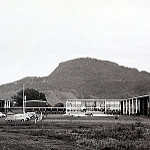

In [0]:
Image.open(train_path+'0.jpg')
# label 0 -> building

In [0]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augument = False):
    self.paths, self.labels = paths, labels
    self.batch_size = batch_size
    self.shape = shape
    self.shuffle = shuffle
    self.use_cache = use_cache
    self.augument = augument
    if use_cache == True:
      self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
      self.is_cached = np.zeros((paths.shape[0]))
    self.on_epoch_end()
    
  def __len__(self):
    return int(np.ceil(len(self.paths)/ float(self.batch_size)))
    
  
  def __getitem__(self,idx):
    indexes = self.indexes[idx * self.batch_size : (idx+1)* self.batch_size]
    paths = np.array(self.paths)[indexes]
    X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
    
    if self.use_cache == True:
          X = self.cache[indexes]
          for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
              image = self.__load_image(path)
              self.is_cached[indexes[i]] = 1
              self.cache[indexes[i]] = image
              X[i] = image
    else:
        for i, path in enumerate(paths):
            X[i] = self.__load_image(path)

    y = self.labels[indexes]
    
    return X, y

  def on_epoch_end(self):
        
    # Updates indexes after each epoch
    self.indexes = np.arange(len(self.paths))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
        
  def __iter__(self):
    """Create a generator that iterate over the Sequence."""
    for item in (self[i] for i in range(len(self))):
        yield item

  def __load_image(self, path):
    im = cv2.imread(path)
    im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
    im = np.divide(im, 255)
    return im
  
def getDataset(id,label):
    paths = [train_path+i for i in id.values]
    labels = to_categorical(label,num_classes = 6)
    return paths, labels
 
train_paths, train_labels = getDataset(X_train,y_train)
train_generator = DataGenerator(train_paths, train_labels, BATCH_SIZE, SHAPE)

val_paths, val_labels = getDataset(X_val,y_val)
val_generator = DataGenerator(val_paths, val_labels, BATCH_SIZE, SHAPE)

lbl = np.zeros(len(test))
test_paths, test_labels = getDataset(test.image_name, lbl)
test_generator = DataGenerator(test_paths, test_labels, BATCH_SIZE, SHAPE)

In [37]:
count = 0
for i in train_generator:
  print(i[0].shape,i[1].shape)
  count+=1
  if count>20:break

(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)
(32, 250, 250, 3) (32, 6)


# CNN Classifier

In [0]:
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=( 100, 100, 3)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('sigmoid'))
#model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8, verbose=1, mode='auto', restore_best_weights=True)

# Train model on dataset
start_time = time()
model.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                    use_multiprocessing=True,
                    epochs=50,
                    workers=6,
                   callbacks=[reduceLROnPlato, earlyStopping])
print(time()-start_time)


Epoch 1/50
373/373 [==============================] - 63s 169ms/step - loss: 0.3972 - acc: 0.8314 - val_loss: 0.2811 - val_acc: 0.8731
Epoch 2/50
373/373 [==============================] - 61s 163ms/step - loss: 0.3278 - acc: 0.8597 - val_loss: 0.2497 - val_acc: 0.8858
Epoch 3/50
373/373 [==============================] - 61s 163ms/step - loss: 0.3025 - acc: 0.8689 - val_loss: 0.2551 - val_acc: 0.8882
Epoch 4/50
373/373 [==============================] - 61s 165ms/step - loss: 0.2712 - acc: 0.8809 - val_loss: 0.2054 - val_acc: 0.9117
Epoch 5/50
373/373 [==============================] - 62s 166ms/step - loss: 0.2543 - acc: 0.8911 - val_loss: 0.2041 - val_acc: 0.9137
Epoch 6/50
373/373 [==============================] - 62s 165ms/step - loss: 0.2356 - acc: 0.9003 - val_loss: 0.1895 - val_acc: 0.9249
Epoch 7/50
373/373 [==============================] - 61s 164ms/step - loss: 0.2194 - acc: 0.9060 - val_loss: 0.1999 - val_acc: 0.9202
Epoch 8/50
373/373 [==============================] - 6

In [0]:
score = model.predict_generator(test_generator)
predicted_class_indices=np.argmax(score,axis=1)
sample_submission.label = predicted_class_indices
sample_submission.to_csv('submit1104_2.csv',index=False)

In [0]:
sample_submission.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


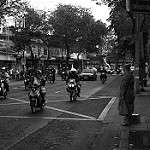

In [0]:
Image.open(train_path+'3.jpg')
# predicted value - 5 -> street

In [0]:
from google.colab import files
files.download('submit1104_2.csv')

#Transfer learning

In [0]:
#BASE_MODEL = 'VGG16'
from keras.preprocessing.image import ImageDataGenerator

def transfer_learning(BASE_MODEL,BATCH_SIZE=32):
  if BASE_MODEL=='VGG16':
      from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
  elif BASE_MODEL=='vgg19':
      from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
  elif BASE_MODEL=='ResNet50':
      from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
  elif BASE_MODEL=='InceptionV3':
      from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
  elif BASE_MODEL=='Xception':
      from keras.applications.xception import Xception as PTModel, preprocess_input
  elif BASE_MODEL=='DenseNet169': 
      from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
  elif BASE_MODEL=='DenseNet121':
      from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
  else:
      raise ValueError('Unknown model: {}'.format(BASE_MODEL))
  
  import keras
  keras.backend.set_learning_phase(1)
  
  check_point_name = BASE_MODEL + '.model'
  model_weights = BASE_MODEL + '.h5'

  train_paths, train_labels = getDataset(X_train,y_train)
  train_generator = DataGenerator(train_paths, train_labels, BATCH_SIZE, SHAPE)

  val_paths, val_labels = getDataset(X_val,y_val)
  val_generator = DataGenerator(val_paths, val_labels, BATCH_SIZE, SHAPE)

  lbl = np.zeros(len(test))
  test_paths, test_labels = getDataset(test.image_name, lbl)
  test_generator = DataGenerator(test_paths, test_labels, BATCH_SIZE, SHAPE)

  img_rows, img_cols, img_channel = 250, 250, 3
  base_model = PTModel(weights='imagenet'
                     ,include_top=False, input_shape=(img_rows, img_cols, img_channel), classes = 2)

  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dense(32, activation='relu'))
  add_model.add(Dense(6, activation='sigmoid'))

  model = Model(inputs=base_model.input, outputs=add_model(base_model.output))


#   for layer in base_model.layers:
#       layer.trainable = False

#       if layer.name.startswith('bn'):
#           layer.call(layer.input, training=False)
#   model.layers[-1].trainable = True
#   model.layers[-2].trainable = True


  model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy'])
  
  reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
  earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8, verbose=1, mode='auto')
  checkPoint = ModelCheckpoint(check_point_name, monitor='val_acc', save_best_only=True)
  
  start_time = time()
  model.fit_generator(
          train_generator,
          epochs=16,
          validation_data=val_generator,
          #class_weight = class_weights,
          callbacks=[reduceLROnPlato, earlyStopping])
  model.save_weights(model_weights)

  print('time taken ',(time()-start_time)/60,'min')
  return model

In [0]:
# train last layer
trans_model = transfer_learning('VGG16')

Epoch 1/16
373/373 [==============================] - 47s 125ms/step - loss: 0.4980 - acc: 0.7952 - val_loss: 0.4347 - val_acc: 0.8334
Epoch 2/16
373/373 [==============================] - 45s 122ms/step - loss: 0.4193 - acc: 0.8334 - val_loss: 0.4077 - val_acc: 0.8335
Epoch 3/16
373/373 [==============================] - 45s 122ms/step - loss: 0.3971 - acc: 0.8340 - val_loss: 0.3882 - val_acc: 0.8349
Epoch 4/16
373/373 [==============================] - 45s 122ms/step - loss: 0.3790 - acc: 0.8358 - val_loss: 0.3716 - val_acc: 0.8383
Epoch 5/16
373/373 [==============================] - 45s 122ms/step - loss: 0.3635 - acc: 0.8388 - val_loss: 0.3567 - val_acc: 0.8416
Epoch 6/16
373/373 [==============================] - 45s 122ms/step - loss: 0.3495 - acc: 0.8424 - val_loss: 0.3431 - val_acc: 0.8452
Epoch 7/16
373/373 [==============================] - 45s 122ms/step - loss: 0.3364 - acc: 0.8461 - val_loss: 0.3306 - val_acc: 0.8482
Epoch 8/16
373/373 [==============================] - 4

In [30]:
# train all layers of VGG16 model
trans_model = transfer_learning('VGG16')

Epoch 1/16
373/373 [==============================] - 99s 265ms/step - loss: 0.4133 - acc: 0.8211 - val_loss: 0.2350 - val_acc: 0.9038
Epoch 2/16
373/373 [==============================] - 97s 260ms/step - loss: 0.1795 - acc: 0.9293 - val_loss: 0.1516 - val_acc: 0.9424
Epoch 3/16
373/373 [==============================] - 97s 260ms/step - loss: 0.1345 - acc: 0.9493 - val_loss: 0.1318 - val_acc: 0.9497
Epoch 4/16
373/373 [==============================] - 97s 260ms/step - loss: 0.1163 - acc: 0.9561 - val_loss: 0.1195 - val_acc: 0.9544
Epoch 5/16
373/373 [==============================] - 98s 262ms/step - loss: 0.1056 - acc: 0.9601 - val_loss: 0.1121 - val_acc: 0.9573
Epoch 6/16
373/373 [==============================] - 98s 262ms/step - loss: 0.0972 - acc: 0.9632 - val_loss: 0.1096 - val_acc: 0.9584
Epoch 7/16
373/373 [==============================] - 98s 263ms/step - loss: 0.0898 - acc: 0.9669 - val_loss: 0.1029 - val_acc: 0.9616
Epoch 8/16
373/373 [==============================] - 9

In [0]:
score = trans_model.predict_generator(test_generator)
predicted_class_indices=np.argmax(score,axis=1)
sample_submission.label = predicted_class_indices
sample_submission.to_csv('submit1104_3.csv',index=False)

In [0]:
from google.colab import files
files.download('submit1104_3.csv')

In [41]:
# train all layers of VGG16 model
densnet_model = transfer_learning('DenseNet169')

Epoch 1/16
373/373 [==============================] - 490s 1s/step - loss: 0.2892 - acc: 0.8710 - val_loss: 0.1486 - val_acc: 0.9452
Epoch 2/16
373/373 [==============================] - 455s 1s/step - loss: 0.1137 - acc: 0.9593 - val_loss: 0.1149 - val_acc: 0.9581
Epoch 3/16
373/373 [==============================] - 455s 1s/step - loss: 0.0820 - acc: 0.9718 - val_loss: 0.1031 - val_acc: 0.9635
Epoch 4/16
373/373 [==============================] - 455s 1s/step - loss: 0.0646 - acc: 0.9788 - val_loss: 0.0980 - val_acc: 0.9648
Epoch 5/16
373/373 [==============================] - 454s 1s/step - loss: 0.0529 - acc: 0.9837 - val_loss: 0.0948 - val_acc: 0.9663
Epoch 6/16
373/373 [==============================] - 455s 1s/step - loss: 0.0438 - acc: 0.9877 - val_loss: 0.0933 - val_acc: 0.9664
Epoch 7/16
373/373 [==============================] - 455s 1s/step - loss: 0.0368 - acc: 0.9908 - val_loss: 0.0922 - val_acc: 0.9675
Epoch 8/16
373/373 [==============================] - 455s 1s/step - 

In [0]:
score = densnet_model.predict_generator(test_generator)
predicted_class_indices=np.argmax(score,axis=1)
sample_submission.label = predicted_class_indices
sample_submission.to_csv('submit1104_4.csv',index=False)
from google.colab import files
files.download('submit1104_4.csv')

In [0]:
from google.colab import files
files.download('submit1104_3.csv')